### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Data Preparation

In [2]:
# Select dataset (1 for 2004-2013, 2 for 1973-2013)
num = 2

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df2 = pd.read_csv('Data_1973_2004.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# Extract daily maximum wave heights
daily_max_obs = df1['H'].resample('D').max()
daily_max_pred = df2['H_pred'].resample('D').max()

if num == 1:
    SWH = daily_max_obs
elif num == 2:
    SWH = pd.concat([daily_max_pred, daily_max_obs], axis=0)

### Dispersion Index (Poisson-ness) Test

Dispersion Index (DI) = 2.541
95% CI for DI under Poisson assumption: [0.918, 1.037]
Poisson-like behavior: No


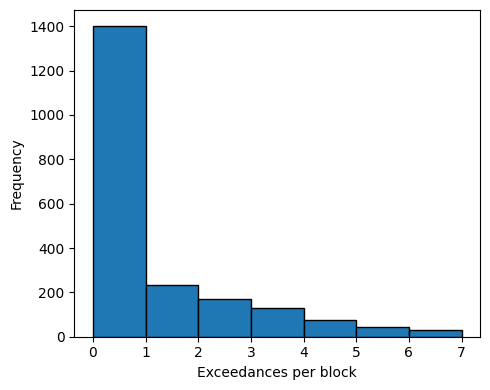

In [3]:
thresh = 5
block_period = 7
alpha = 0.05

# Filter exceedances
exceed = np.array((SWH > thresh).astype(int))

# Determine number of blocks
n_blocks = len(SWH) // block_period
exceed_blocks = exceed[:n_blocks * block_period].reshape((n_blocks, block_period))

# Count number of exceedances in each block
counts = exceed_blocks.sum(axis=1)

# Calculate dispersion index: variance / mean
mean_count = np.mean(counts)
var_count = np.var(counts, ddof=1)
di = var_count / mean_count if mean_count > 0 else np.nan

# Confidence interval from chi-squared distribution
df = len(counts) - 1
ci_low = df * (1 - alpha / 2) / stats.chi2.ppf(1 - alpha / 2, df)
ci_high = df * (1 - alpha / 2) / stats.chi2.ppf(alpha / 2, df)

# Check if dispersion index is within expected Poisson range
poisson_like = (di >= ci_low) and (di <= ci_high)

print(f"Dispersion Index (DI) = {di:.3f}")
print(f"{(1 - alpha) * 100:.0f}% CI for DI under Poisson assumption: [{ci_low:.3f}, {ci_high:.3f}]")
print(f"Poisson-like behavior: {'Yes' if poisson_like else 'No'}")

# Plot histogram of block counts
plt.figure(figsize=(5, 4))
plt.hist(counts, bins='auto', edgecolor='black')
plt.xlabel('Exceedances per block')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()